In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, multiprocessing as mp
from numpy import random
import torch, cv2, time, random, os, threading, pickle

In [2]:
DTYPE = {
    'boolean': torch.bool, 'ui8': torch.uint8, 'i8': torch.int8, 'i16': torch.int16, 'i32': torch.int32, 'i64': torch.int64, 
    'f16': torch.float16, 'f32': torch.float32, 'f64': torch.float64, 'f64Complex': torch.complex64, 'f128Complex': torch.complex128
}
DEVICE = {
    'auto': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), 
    'cpu': torch.device('cpu'), 
    'cuda0': torch.device('cuda:0')
}

DEVICE_CHOICE = 'auto'

In [10]:
class DNN(object):
    def __init__(self, layers=(10, 20, 10), aFunc=('cos', 'PRelu', 'PRelu', 'sin')):
        self.layerNum = len(layers)
        assert self.layerNum >= 1
        torch.manual_seed(0)
        self.backProp = {
            'PRelu': True,  # 如果False, 则 == Leaky Relu
            'Norm': [True] * self.layerNum
        }
        self.paramLimits = {
            'weights': (-100000, 100000), 
            'biases': (-100000, 100000), 
            'relu param': (-100, 100), 
            'BN gamma': (-1000, 1000), 
            'BN beta': (-1000, 1000), 
            'dW': (-1, 1), 
            'dB': (-10, 10), 
            'dReluP': (-10, 10), 
            'dGamma': (-10, 10), 
            'dBeta': (-10, 10)
        }
        self.layerShapes = layers
        self.aFuncChosen = aFunc
        self.defaultLr = 0.0001
        self.lr = {
            'weight': self.defaultLr * 250,
            'bias': self.defaultLr * 5000,
            'relu param': self.defaultLr * 10, 
            'BN gamma': self.defaultLr, 
            'BN beta': self.defaultLr
        }
        self.inputs = None
        self.targetY = None
        self.weights = [None] * self.layerNum
        self.biases = [None] * self.layerNum
        self.reluParam = [0.01] * self.layerNum
        self.layers = {
            'Z': [None] * self.layerNum, 
            'N': [None] * self.layerNum, 
            'A': [None] * self.layerNum
        }
        self.BN = {
            'epsilon': 1e-5, 
            'gamma': [1] * self.layerNum, 
            'beta': [0] * self.layerNum, 
            'cache': [None] * self.layerNum
        }
        self.activFunc = {
            'PRelu': lambda x, i: torch.max(x, x * self.reluParam[i]), 
            'sigmoid': lambda x: 1/(1+torch.exp(-x)), 
            'softmax': lambda x: torch.exp(x - torch.max(x)) / torch.sum(torch.exp(x - torch.max(x))), 
            'tanh': lambda x: torch.tanh(x), 
            'sin': lambda x: torch.sin(x), 
            'cos': lambda x: torch.cos(x), 
            'linear': lambda x: x
        }
        self.activFuncDer = {
            'PRelu': self._PReluDer,  
            'sigmoid': lambda x: self.activFunc['sigmoid'](x) * (1 - self.activFunc['sigmoid'](x)), 
            'softmax': lambda x, a: self.activFunc['softmax'](x) * (a - self.activFunc['softmax'](x)), 
            'tanh': lambda x: 1 - torch.tanh(x) ** 2, 
            'sin': lambda x: torch.cos(x), 
            'cos': lambda x: -torch.sin(x), 
            'linear': lambda x: 1
        }
        self.lossFunc = {
            'mse': lambda predictY, targetY: (targetY - predictY) ** 2, 
            'bce': lambda predictY, targetY: targetY * torch.log(predictY) + (1 - targetY) * torch.log(1 - predictY)
        }
        self.lossFuncDer = {
            'mse': lambda predictY, targetY: 2 * (targetY - predictY), 
            'bce': lambda predictY, targetY: Y / predictY + (targetY - 1) / (1 - predictY)
        }
    
    def _dA_dReluP(self, x, i):
        data = x.clone()
        data[data > 0] = 0
        data[data <= 0] = torch.mean(data[data <= 0])
        return data
    
    def _PReluDer(self, x, i): 
        data = x.clone()
        data[data > 0] = 1
        data[data <= 0] = self.reluParam[i]
        return data
    
    def setBackProp(self, **kwargs):
        '''
        Keys: PRelu, Norm
        Values: True, (True, False ..)
        '''
        for k, v in kwargs.items():
            try:
                self.backProp[k] = v
            except:
                continue
            
    def batchNorm(self, x, layerIter):
        mean = torch.mean(x)
        variance = torch.mean((x - mean) ** 2)
        # normalize
        fenzi = (x - mean) * 1.0
        fenmu = torch.sqrt(variance + self.BN['epsilon'])
        # * 1.0 是转换成float
        xNorm = fenzi / fenmu
        cache = {
            'BNmean': mean, 
            'BNvariance': variance, 
            'BNfenzi': fenzi, 
            'BNfenmu': fenmu
        }
        self.BN['cache'][layerIter] = cache
        return self.BN['gamma'][layerIter] * xNorm + self.BN['beta'][layerIter]
    
    def setToLimit(self, data, limits):
        x = data.clone()
        x[x<limits[0]] = limits[0]
        x[x>limits[1]] = limits[1]
        return x
    
    # 生成 w、b, 以x的形状是 m x 1
    def genParam(self, x):
        self.inputs = x
        column = x.shape[0]
        for i, r in enumerate(self.layerShapes):
#             print('row: ', row, '\ncolumn: ', column)
            self.weights[i] = torch.ones(r, column, dtype=DTYPE['f64'], device=DEVICE[DEVICE_CHOICE])
            self.biases[i] = torch.zeros(r, 1, dtype=DTYPE['f64'], device=DEVICE[DEVICE_CHOICE])
            column = r

    # 前向传播函数
    def forward(self, x):
        inputs = x
#         print('inputs.shape: ', inputs.shape)
        for i in range(self.layerNum):
#             print(f'w[{i}].shape: ', self.weights[i].shape)
#             print(f'b[{i}].shape: ', self.biases[i].shape)
            layerNameFirst = 'N' if self.backProp['Norm'][i] else 'Z'
            self.layers['Z'][i] = self.weights[i] @ inputs + self.biases[i]
            self.layers['N'][i] = self.batchNorm(self.layers['Z'][i], i)
            if self.aFuncChosen[i] == 'PRelu':
                self.layers['A'][i] = self.activFunc[self.aFuncChosen[i]](self.layers[layerNameFirst][i], i)
            else:
                self.layers['A'][i] = self.activFunc[self.aFuncChosen[i]](self.layers[layerNameFirst][i])
            inputs = self.layers['A'][i]
#             print(f'layer[{i}].shape: ', self.layers['A'][i].shape)
    
    # 反向传播函数
    # input = x, Z = W @ input + b, N = batchNormalize(Z), Y_preditc = activateFunc(N), L = lossFunc(Y_predict)
    # 根据链式法则 dL / dW = (dL / dY_predict) * (dY_predict / dN) * (dN / dZ) * (dZ / dW)
    # dL / dY_predict = lossFunc_Der, dY_predict / dN = activateFunc_Der, dN/dZ = gamma/sqrt(variance+epsilon), dZ/dW = input
    # ==> dL / dW = lossFunc_Der(Y_predict) * activateFunc_Der(Z) * gamma/sqrt(variance+epsilon) * input
    # 同理可证 dL / db = lossFunc_Der(Y_predict) * activateFunc_Der(Z) * gamma/sqrt(variance+epsilon) * 1
    def backprop(self):
        '''
        尚未完成
        '''
            
        dW = [None] * self.layerNum
        dB = [None] * self.layerNum
        dReluP = [None] * self.layerNum
        dGamma = [None] * self.layerNum
        dBeta = [None] * self.layerNum
        dActivation = [None] * self.layerNum
        
        dL_Div_dYtrain = self.lossFuncDer['mse'](self.layers['A'][-1], self.targetY)
        
        for i in reversed(range(self.layerNum)):
#             print('i: ', i)
            layerNameFirst = 'N' if self.backProp['Norm'][i] else 'Z'
            if self.aFuncChosen[i] == 'PRelu':
                dActivation[i] = self.activFuncDer[self.aFuncChosen[i]](self.layers[layerNameFirst][i], i)
            else:
                dActivation[i] = self.activFuncDer[self.aFuncChosen[i]](self.layers[layerNameFirst][i])
#             print(f'weight[{i}] shape: {self.weights[i].shape} \nbias[{i}] shape: {self.biases[i].shape} \n')
            if i == self.layerNum - 1:
                dBeta[i] = dB[i] = dL_Div_dYtrain * dActivation[i]
                dGamma[i] = dBeta[i] * (self.BN['cache'][i]['BNfenzi'] / self.BN['cache'][i]['BNfenmu'])
                if self.backProp['Norm'][i]:
                    dB[i] *= self.BN['gamma'][i] / self.BN['cache'][i]['BNfenmu']
                if self.backProp['PRelu']:
                    dReluP[i] = torch.mean(dL_Div_dYtrain * self.layers[layerNameFirst][i])
                dW[i] = dB[i] @ torch.transpose(self.layers['A'][i-1], 0, 1)
            else:
                dB[i] = (torch.transpose(self.weights[i+1], 0, 1) @ dB[i+1]) * dActivation[i]
                dW[i] = dB[i] @ torch.transpose(self.layers['A'][i-1], 0, 1)
                dBeta[i] = torch.transpose(self.weights[i+1], 0, 1) @ (dBeta[i+1] * (self.BN['gamma'][i+1] / self.BN['cache'][i+1]['BNfenmu']))
                dGamma[i] = dBeta[i] * (self.BN['cache'][i]['BNfenzi'] / self.BN['cache'][i]['BNfenmu'])
                if self.backProp['PRelu']:
                    dReluP[i] = torch.mean(torch.transpose(self.weights[i], 0, 1) @ dB[i] * self.layers[layerNameFirst][i-1])
                    
#             print(f'dReluP[{i}]: {dReluP[i]}')
            dB_Limited = self.setToLimit(dB[i], self.paramLimits['dB'])
            dW_Limited = self.setToLimit(dW[i], self.paramLimits['dW'])
        
            self.biases[i] += dB_Limited * self.lr['bias']
            self.weights[i] += dW_Limited * self.lr['weight']
            
#             self.biases[i] = self.setToLimit(self.biases[i], self.paramLimits['biases'])
#             self.weights[i] = self.setToLimit(self.weights[i], self.paramLimits['weights'])
            
            if self.aFuncChosen[i] == 'PRelu' and self.backProp['PRelu']:
                dReluP_Limited = self.setToLimit(dReluP[i], self.paramLimits['dReluP']).item()
                self.reluParam[i] += dReluP_Limited * self.lr['relu param']
#                 print('PRelu back proped')
            if self.backProp['Norm'][i]:
                dBeta_Limited = torch.mean(self.setToLimit(dBeta[i], self.paramLimits['dBeta'])).item()
                dGamma_Limited = torch.mean(self.setToLimit(dGamma[i], self.paramLimits['dGamma'])).item()
                self.BN['beta'][i] += dBeta_Limited * self.lr['BN gamma']
                self.BN['gamma'][i] += dGamma_Limited * self.lr['BN beta']
#                 print('BN back proped')
#             print(self.reluParam)
            
    def train(self, inputs, targetY, nanInvestigate=40, epoch = 1000):
        self.targetY = targetY
        for e in range(epoch):
            self.forward(self.inputs)
            loss = torch.norm(self.layers['A'][-1] - self.targetY)
            print(e, f': loss = {loss}')
            if loss < 5.0 or e > int(epoch/2):
                for k,v in self.lr.items():
                    self.lr[k] /= 2
            if loss < 2.0 or e > int(epoch*0.9):
                for k,v in self.lr.items():
                    self.lr[k] /= 5
            if loss < 1.0 or torch.isnan(loss):
                return
#                 print(f'{i} Loss: ', torch.mean(self.lossFunc['mse'](self.layers['A'][-1], self.targetY)).item())
#                 print(epoch/100, ': \n', torch.transpose(self.layers['A'][-1], 0, 1))
            self.backprop()
            if e > nanInvestigate and nanInvestigate > 0:
                self.saveParams('d:\\nanInvest_'+str(e)+'.pt', True)
                
    def printShape(self):
        for i in range(self.layerNum):
            print(f'weight[{i}] shape: ', self.weights[i].shape)
            print(f'bias[{i}] shape: ', self.biases[i].shape)
            print(f'Relu Params[{i}]: ', self.reluParam[i])
            print(f'BN gamma[{i}]: ', self.BN['gamma'][i])
            print(f'BN beta[{i}]: ', self.BN['beta'][i])
#             print(f'Z layer shape: ', self.layers['Z'][i].shape)
#             print(f'N layer shape: ', self.layers['N'][i].shape)
#             print(f'A layer shape: ', self.layers['A'][i].shape)
    
    def saveParams(self, PATH, layers=False, reluParam=False, BN=False):
        params = {
            'weight': self.weights, 
            'bias': self.biases
        }
        if layers:
            params['layers'] = self.layers
        if reluParam:
            params['reluParam'] = self.reluParam
        if BN:
            params['BN'] = self.BN
        torch.save(params, PATH)
        
    def readParams(self, PATH, layers=False, reluParam=False, BN=False):
        params = torch.load(PATH)
        self.weights = params['weight']
        self.biases = params['bias']
        if layers:
            self.layers = params['layers']
        if reluParam:
            self.reluParam = params['reluParam']
        if BN:
            self.BN = params['BN']
    
    # 预测
    def predict(self, x):
        self.forward(x)
        predictY = self.layers['A'][-1]
        print('output: ', predictY.squeeze())
        return predictY

weight[0] shape:  torch.Size([50, 40000])
bias[0] shape:  torch.Size([50, 1])
Relu Params[0]:  0.01
BN gamma[0]:  1
BN beta[0]:  0
weight[1] shape:  torch.Size([50, 50])
bias[1] shape:  torch.Size([50, 1])
Relu Params[1]:  0.01
BN gamma[1]:  1
BN beta[1]:  0
weight[2] shape:  torch.Size([50, 50])
bias[2] shape:  torch.Size([50, 1])
Relu Params[2]:  0.01
BN gamma[2]:  1
BN beta[2]:  0
weight[3] shape:  torch.Size([40000, 50])
bias[3] shape:  torch.Size([40000, 1])
Relu Params[3]:  0.01
BN gamma[3]:  1
BN beta[3]:  0
0 : loss = 208.19161277411558
1 : loss = 198.9244203185686
2 : loss = 19.478845025311294
3 : loss = 19.335545455959753
4 : loss = 19.348580158140674
5 : loss = 19.332170722966715
6 : loss = 19.34523353826736
7 : loss = 19.32876968058734
8 : loss = 19.341863737855675
9 : loss = 19.32534289987702
10 : loss = 19.33846917768438
11 : loss = 19.32188882730973
12 : loss = 17.15591984239671
13 : loss = 17.181275936346868
14 : loss = 17.15072273892209
15 : loss = 17.15156249240909
16

18 : loss = 2156.7244237262466
19 : loss = 2156.7244237262466
0 : loss = 2316.033338994361
1 : loss = 2316.033338994361
2 : loss = 2316.033338994361
3 : loss = 2316.033338994361
4 : loss = 2316.033338994361
5 : loss = 2316.033338994361
6 : loss = 2316.033338994361
7 : loss = 2316.033338994361
8 : loss = 2316.033338994361
9 : loss = 2316.033338994361
10 : loss = 2316.033338994361
11 : loss = 2316.033338994361
12 : loss = 2316.033338994361
13 : loss = 2316.033338994361
14 : loss = 2316.033338994361
15 : loss = 2316.033338994361
16 : loss = 2316.033338994361
17 : loss = 2316.033338994361
18 : loss = 2316.033338994361
19 : loss = 2316.033338994361
0 : loss = 2559.942861267647
1 : loss = 2559.942861267647
2 : loss = 2559.942861267647
3 : loss = 2559.942861267647
4 : loss = 2559.942861267647
5 : loss = 2559.942861267647
6 : loss = 2559.942861267647
7 : loss = 2559.942861267647
8 : loss = 2559.942861267647
9 : loss = 2559.942861267647
10 : loss = 2559.942861267647
11 : loss = 2559.94286126764

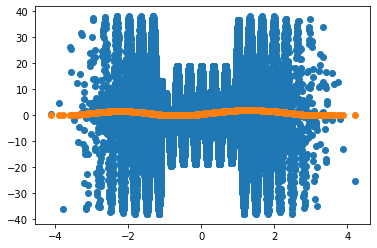

weight[0] shape:  torch.Size([50, 40000])
bias[0] shape:  torch.Size([50, 1])
Relu Params[0]:  0.0
BN gamma[0]:  0.9986574223629516
BN beta[0]:  0.0013425776370484957
weight[1] shape:  torch.Size([50, 50])
bias[1] shape:  torch.Size([50, 1])
Relu Params[1]:  -0.013548843883268612
BN gamma[1]:  0.9996887551378758
BN beta[1]:  0.0013425776370484957
weight[2] shape:  torch.Size([50, 50])
bias[2] shape:  torch.Size([50, 1])
Relu Params[2]:  0.01599660829069332
BN gamma[2]:  1.0009183023395485
BN beta[2]:  0.0014755417994722323
weight[3] shape:  torch.Size([40000, 50])
bias[3] shape:  torch.Size([40000, 1])
Relu Params[3]:  0.010152409466860779
BN gamma[3]:  1
BN beta[3]:  0
output:  tensor([-5.9289e-04,  3.4964e-01,  7.0100e-01,  ...,  1.7617e+00,
         9.2051e-01,  3.6123e-01], device='cuda:0', dtype=torch.float64)


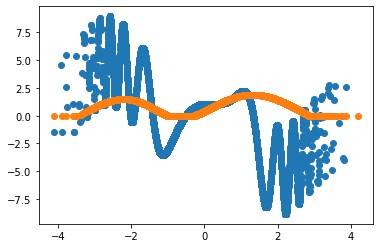

In [18]:
if __name__ == '__main__':
    layers = (50, 50, 50, 40000)
    aFuncs = ('PRelu', 'PRelu', 'PRelu', 'PRelu')
    normLayer = (True, True, True, False)
    epoch = 20
    nn1 = DNN(layers, aFuncs)
    nn1.setBackProp(PRelu=True, Norm=normLayer)
    # 训练数据
    # 所有input全部变型成 m x 1 的形状
    testInput = torch.randn((200, 200), dtype=DTYPE['f64'], device=DEVICE[DEVICE_CHOICE])
    testInput = testInput.view(-1, 1)
    # 生成权重和偏移
    nn1.genParam(testInput)
    nn1.printShape()
    # 训练
    for i in range(1, 20, 1):
        # 生成目标输出
        targetY = (i*torch.sin(testInput**i) + i*torch.cos(i*testInput-i)) * torch.tanh(testInput+i)
        nn1.train(testInput, targetY, nanInvestigate=0, epoch=epoch)
    # 预测
    estimateY = nn1.predict(testInput)
    
    plt.scatter(testInput.cpu().numpy().flatten(), targetY.cpu().numpy().flatten())
    plt.scatter(testInput.cpu().numpy().flatten(), estimateY.cpu().numpy().flatten())
    plt.show()
    nn1.printShape()
    
    # 测试数据
    testInput2 = torch.randn((200, 200), dtype=DTYPE['f64'], device=DEVICE[DEVICE_CHOICE]).view(-1, 1)
    targetY2 = 4*torch.sin(testInput2**3) + 2*torch.cos(2*testInput2-1) - 3*torch.tanh(testInput2)
    estimateY2 = nn1.predict(testInput2)
    plt.scatter(testInput2.cpu().numpy().flatten(), targetY2.cpu().numpy().flatten())
    plt.scatter(testInput.cpu().numpy().flatten(), estimateY2.cpu().numpy().flatten())
    plt.show()